In [1]:
import os
os.chdir('/Users/Sinead/DC-project/')
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()
import numpy as np
import script
%matplotlib inline
import plotly 
plotly.offline.init_notebook_mode()
import find_eyes_reshape as fer
import nibabel as nib
import vtk
import pylab

/Users/Sinead/anaconda/envs/project/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
PathDicoms = np.array(
    [['/Volumes/Backup Data/ASDH Samples/Sample1/Post-operative/R-N11-109/HeadSpi  1.0  J40s  3', 'Sample 1'],
     ['/Volumes/Backup Data/ASDH Samples/Sample2/Original/Post-op.nii', 'Sample 2'],
     ['/Volumes/Backup Data/ASDH Samples/Sample3/Post-op', 'Sample 3'],
     ['/Volumes/Backup Data/ASDH Samples/Sample4/Post-op', 'Sample 4'],
     ['/Volumes/Backup Data/ASDH Samples/Sample5/Post-op', 'Sample 5'],
     ['/Volumes/Backup Data/ASDH Samples/SampleA/Post-op', 'Sample A'],
     ['/Volumes/Backup Data/ASDH Samples/SampleB/Post-op', 'Sample B'],
     ['/Volumes/Backup Data/ASDH Samples/SampleC/Post-op', 'Sample C'],
     ['/Volumes/Backup Data/ASDH Samples/SampleD/Post-op', 'Sample D'],
     ['/Volumes/Backup Data/ASDH Samples/SampleF/Post-op', 'Sample F'],
     ['/Volumes/Backup Data/ASDH Samples/SampleG/Post-op', 'Sample G'],
     ['/Volumes/Backup Data/ASDH Samples/SampleH/Post-op', 'Sample H'],
     ['/Volumes/Backup Data/ASDH Samples/SampleI/Post-op', 'Sample I']])

script.py:140: SyntaxWarning:

import * only allowed at module level



Sample 1 thresholding complete
Sample 1 reshaping complete
Sample 1 eyes found
Sample 1 skews corrected
Starting ellipse fitting
Sample 1 ellipses found
Optimization terminated successfully.
         Current function value: -17.902075
         Iterations: 42
         Function evaluations: 84
Sample 1 plane found
Sample 1 commence figure saving
Sample 2 thresholding complete
Sample 2 reshaping complete
Optimization terminated successfully.
         Current function value: -21.862500
         Iterations: 37
         Function evaluations: 74
Sample 2 eyes found
Sample 2 skews corrected
Starting ellipse fitting
Sample 2 ellipses found
Optimization terminated successfully.
         Current function value: -18.129113
         Iterations: 37
         Function evaluations: 74
Sample 2 plane found
Sample 2 commence figure saving
Sample 3 thresholding complete
Sample 3 reshaping complete
Sample 3 eyes found
Sample 3 skews corrected
Starting ellipse fitting
Sample 3 ellipses found
Optimization te

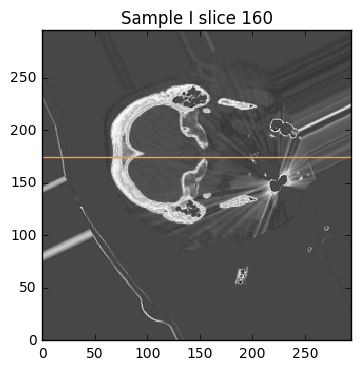

In [8]:
reload(script)
for i in range(0, PathDicoms.shape[0], 1):
    PathDicom = PathDicoms[i][0]
    samp = PathDicoms[i][1]
    # threshold CT scan for eyes and bone and store in 2 different arrays
    if PathDicom.endswith('.nii'):
        thresholded_bone=script.threshim_nii(1100,1500)
        array_bone, ConstPixelSpacing = script.vtk2np_nii(thresholded_bone)
        thresholded_eyes = script.threshim_nii(0,80) # remove soft tissue
        array_eyes, ConstPixelSpacing = script.vtk2np_nii(thresholded_eyes)
        thresholded_visual=script.threshim_nii(-100,1500) 
        array_visual, ConstPixelSpacing = script.vtk2np_nii(thresholded_visual) 
    else:
        thresholded_bone=script.threshim_dicom(1100,1500)
        array_bone, ConstPixelSpacing = script.vtk2np(thresholded_bone)
        thresholded_eyes = script.threshim_dicom(0,80) # remove soft tissue
        array_eyes, ConstPixelSpacing = script.vtk2np(thresholded_eyes)
        thresholded_visual=script.threshim_dicom(-100,1500) 
        array_visual, ConstPixelSpacing = script.vtk2np(thresholded_visual) 
        
    print '{} thresholding complete'.format(samp)
    # reshape the arrays - don't run this twice
    array_bone = script.reshape(array_bone, ConstPixelSpacing, 220, 160, array_bone.shape[0], array_bone.shape[2])
    array_eyes = script.reshape(array_eyes, ConstPixelSpacing, 220, 160, array_eyes.shape[0], array_eyes.shape[2])
    array_visual = script.reshape(array_visual, ConstPixelSpacing, 220, 160, array_visual.shape[0], array_visual.shape[2])
    print '{} reshaping complete'.format(samp)
    H, edges, data, hist_data_2c = fer.hist3d_all(array_eyes)
    ranges_1, ranges_2, certainty = fer.ranges(H,edges)
    c1,c2 = fer.coords(hist_data_2c, ranges_1, ranges_2)
    print '{} eyes found'.format(samp)
    # fer.check_coords(c1,c2,array_eyes)
    angle1, angle2 = fer.angles_from_eyes(c1,c2)
    rotated1, rotated2 = fer.correct_skews(angle1,angle2,array_bone)
    _, array_visual = fer.correct_skews(angle1,angle2,array_visual)
    _, array_eyes = fer.correct_skews(angle1,angle2,array_eyes)
    print '{} skews corrected'.format(samp)
    angles, xcentroids, ycentroids, xmajor_axis_points, ymajor_axis_points = script.ellipses(rotated2)
    print '{} ellipses found'.format(samp)
    slices, slice_angles = script.select_ellipses_range(angles)    
    head_angles = [angles[i] for i in slices]
    head_x = [xcentroids[i] for i in slices] 
    head_y = [ycentroids[i] for i in slices] 
    a,b,c,d = script.find_plane_from_ellipses(rotated2, array_eyes, slices, head_x, head_y, head_angles)
    print '{} plane found'.format(samp)
    from matplotlib.colors import LinearSegmentedColormap
    cmap1 = LinearSegmentedColormap.from_list("my_colormap", ((0,0,0),(0.2, 0.2, 0.2),(0.3, 0.3, 0.3), (0.4, 0.4, 0.4),(0.5, 0.5, 0.5), (0.6,0.6,0.6),(0.7, 0.7, 0.7), (0.8, 0.8, 0.8), (0.9, 0.9, 0.9),(0.8, 0.8, 0.8),(0.7, 0.7, 0.7),(0.8, 0.8, 0.8),(0.9, 0.9, 0.9),(1,1,1)), N=256, gamma=1.0)
    print '{} commence figure saving'.format(samp)
    for slice_no in range(0,rotated2.shape[2],5):
        slice_ = array_visual[:,:,slice_no]
        plt.clf()
        plt.imshow(slice_, cmap=cmap1, interpolation='nearest')
        plt.xlim([0,array_visual.shape[1]])
        plt.ylim([0,array_visual.shape[0]])
        x = np.linspace(0,slice_.shape[0], 2)
        y = (d-c*slice_no-a*x)/b
        plt.plot(x,y, color='orange')
        plt.title('{} slice {}'.format(samp, slice_no))
        pylab.savefig('{}_slice_{}.png'.format(samp, slice_no))


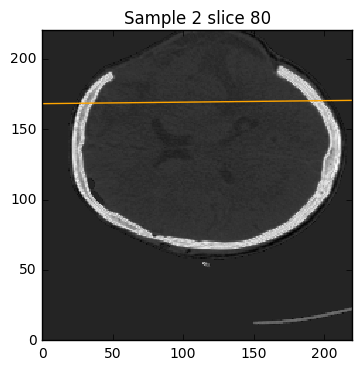

In [174]:
from matplotlib.colors import LinearSegmentedColormap
cmap1 = LinearSegmentedColormap.from_list("my_colormap", ((0,0,0),(0.2, 0.2, 0.2),(0.35, 0.35, 0.35), (0.4, 0.4, 0.4),(0.5, 0.5, 0.5), (0.6,0.6,0.6),(0.7, 0.7, 0.7), (0.8, 0.8, 0.8), (0.9, 0.9, 0.9),(0.8, 0.8, 0.8),(0.7, 0.7, 0.7),(0.8, 0.8, 0.8),(0.9, 0.9, 0.9),(1,1,1)), N=256, gamma=1.0)
slice_no = 80
slice_ = array_visual[:,:,slice_no]
plt.imshow(slice_, cmap=cmap1, interpolation='nearest')
plt.xlim([0,220])
plt.ylim([0,220])
x = np.linspace(0,slice_.shape[0], 2)
y = (d-c*slice_no-a*x)/b
plt.plot(x,y, color='orange')
plt.title('{} slice {}'.format(samp, slice_no))
pylab.savefig('{}_slice_{}.png'.format(samp, slice_no))

In [38]:
script.visualise_single(array_visual, a,b,c,d, 75)